In [1]:
from __future__ import absolute_import, division
from tqdm.auto import tqdm
import torch
from trainingUtils import MultipleOptimizer, MultipleScheduler, compute_kernel, compute_mmd
from models import Encoder,Decoder,VAE,CellStateEncoder,CellStateDecoder, CellStateVAE,SimpleEncoder
# import argparse
import numpy as np
import pandas as pd
import sys
import random
import os
from IPython.display import clear_output
from matplotlib import pyplot as plt

#from scipy.stats import pearsonr
from scipy.stats import spearmanr
from evaluationUtils import r_square,get_cindex,pearson_r,pseudoAccuracy

In [2]:
device = torch.device('cuda')

In [3]:
# Initialize environment and seeds for reproducability
torch.backends.cudnn.benchmark = True


def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = False
    
# Read data
cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_landmarks_HT29_A375.csv',index_col = 0)
#cmap = pd.read_csv('../preprocessing/preprocessed_data/cmap_HT29_A375.csv',index_col = 0)
#cmap_tf = pd.read_csv('../../../L1000_2021_11_23/cmap_compounds_tfs_repq1_tas03.tsv',
#                       sep='\t', low_memory=False, index_col=0)

gene_size = len(cmap.columns)
samples = cmap.index.values
# gene_size = len(cmap_tf.columns)
# samples = cmap_tf.index.values

# sampleInfo = pd.read_csv('../preprocessing/preprocessed_data/conditions_HT29_A375.csv',index_col = 0)

In [4]:
sampleInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/a375_unpaired.csv',index_col=0)
sampleInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/ht29_unpaired.csv',index_col=0)
sampleInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/alldata/paired_a375_ht29.csv',index_col=0)

In [5]:
# Create a train generators
def getSamples(N, batchSize):
    order = np.random.permutation(N)
    outList = []
    while len(order)>0:
        outList.append(order[0:batchSize])
        order = order[batchSize:]
    return outList

# Cross validation

In [6]:
from math import floor
#sampleA375 = sampleInfo[sampleInfo['cell_iname']=='A375']
#sampleHT29 = sampleInfo[sampleInfo['cell_iname']=='HT29']
index_a375 = sampleInfo_a375.index
index_ht29 = sampleInfo_ht29.index
index_paired = sampleInfo_paired.index
n_vals_a375 = floor(len(index_a375)*0.1)
n_vals_ht29 = floor(len(index_ht29)*0.1)
n_vals_paired = floor(len(index_paired)*0.1)

In [7]:
n_vals_paired

33

In [8]:
# # Split
# for i in range(10):
#     # Network
#     valInfo_a375 = sampleInfo_a375.loc[index_a375[-n_vals_a375:],:]
#     valInfo_ht29 = sampleInfo_ht29.loc[index_ht29[-n_vals_ht29:],:]
#     valInfo_paired = sampleInfo_paired.loc[index_paired[-n_vals_paired:],:]
#     trainInfo_a375 = sampleInfo_a375.drop(valInfo_a375.index)
#     trainInfo_ht29 = sampleInfo_ht29.drop(valInfo_ht29.index)
#     trainInfo_paired = sampleInfo_paired.drop(valInfo_paired.index)
#     #trainInfo = pd.concat([trainInfo_a375,trainInfo_ht29],axis=0)
#     #valInfo = pd.concat([valInfo_a375,valInfo_ht29],axis=0)
#     index_a375 = index_a375.drop(valInfo_a375.index)
#     index_ht29 = index_ht29.drop(valInfo_ht29.index)
#     index_paired = index_paired.drop(valInfo_paired.index)
    
#     trainInfo_a375.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i)
#     valInfo_a375.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i)
    
#     trainInfo_ht29.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i)
#     valInfo_ht29.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i)
    
#     trainInfo_paired.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i)
#     valInfo_paired.to_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i)

### Pretrain encoder,decoder

In [8]:
# Drop later validation sets
valInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_0.csv',index_col=0)
valInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_0.csv',index_col=0)
valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_0.csv',index_col=0)

for i in range(1,10):
    valInfo_a375 = pd.concat([valInfo_a375,
                              pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)])
    valInfo_ht29 = pd.concat([valInfo_ht29,
                              pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)])
    valInfo_paired = pd.concat([valInfo_paired,
                              pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)])
    
valInfo_paired = valInfo_paired.drop_duplicates()
valInfo_ht29 = valInfo_ht29.drop_duplicates()
valInfo_a375 = valInfo_a375.drop_duplicates()

In [9]:
cmap_all = pd.read_csv('../preprocessing/preprocessed_data/all_cmap_landmarks.csv',index_col = 0)
cmap_all = cmap_all.drop(valInfo_a375.sig_id)
cmap_all = cmap_all.drop(valInfo_ht29.sig_id)
cmap_all = cmap_all.drop(valInfo_paired['sig_id.x'])
cmap_all = cmap_all.drop(valInfo_paired['sig_id.y'])

cmap_train = cmap_all.sample(frac=0.8)
cmap_val = cmap_all.drop(cmap_train.index)
N = len(cmap_train)
#best_val_pear = -100.
#best_ep = 0

In [10]:
NUM_EPOCHS = 500
bs = 512
master_encoder = Encoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())
master_decoder = Decoder(292,[384,640],gene_size,dropRate=0.1, activation=torch.nn.ELU())
master_autoencoder = VAE(master_encoder,master_decoder,device).to(device)
optimizer = torch.optim.Adam(master_autoencoder.parameters(), lr= 0.0001, weight_decay=0)
init_epochs = 10

In [11]:
for e in range(0, NUM_EPOCHS):
    master_autoencoder.train()
    trainloader = getSamples(N, bs)
    for dataIndex in trainloader:
        optimizer.zero_grad()
        X = torch.tensor(cmap_train.iloc[dataIndex,:].values).float().to(device)
        z_latent , y_pred = master_autoencoder(X)
        true_samples = torch.autograd.Variable(torch.randn(z_latent.shape[0], z_latent.shape[1]), requires_grad=False)
        true_samples = true_samples.to(device)
        fitLoss = torch.mean(torch.mean((y_pred - X)**2,dim=1)) + compute_mmd(true_samples,z_latent)
        L2Loss = master_autoencoder.L2Regularization(0.01)
        loss = fitLoss + L2Loss
        
        loss.backward()

        optimizer.step()
        
        pearson = pearson_r(y_pred.detach().flatten(), X.detach().flatten())
        r2 = r_square(y_pred.detach().flatten(), X.detach().flatten())
        mse = torch.mean(torch.mean((y_pred.detach() - X.detach())**2,dim=1))
        
        outString = 'Epoch={:.0f}/{:.0f}'.format(e+1,NUM_EPOCHS)
        outString += ', r2={:.4f}'.format(r2.item())
        outString += ', pearson={:.4f}'.format(pearson.item())
        outString += ', MSE={:.4f}'.format(mse.item())
        outString += ', loss={:.4f}'.format(loss.item())
        print(outString)
        clear_output(wait=True)

Epoch=500/500, r2=0.3428, pearson=0.7704, MSE=1.0112, loss=1.0546


In [12]:
#master_autoencoder = torch.load('my_results/master_autoencoder.pt')

In [13]:
master_autoencoder.eval()
X_val = torch.tensor(cmap_val.values).float().to(device)
zval , yval = master_autoencoder(X_val)
valpear = pearson_r(yval.detach(), X_val.detach()).detach()

In [14]:
print(valpear.item())

0.763538658618927


In [15]:
master_autoencoder.eval()
X = torch.tensor(cmap_train.values).float().to(device)
z , y = master_autoencoder(X)
pear = pearson_r(y.detach(), X.detach()).detach()
print(pear.item())

0.7950395345687866


In [16]:
# print(best_ep)
# print(best_val_pear)

In [17]:
torch.save(master_autoencoder,'../results/my_results/landmark_master_vae.pt')
#torch.save(master_encoder,'../results/my_results/master_encoder.pt')
#torch.save(master_decoder,'../results/my_results/master_decoder.pt')

### Load pre-trained auto-encoder

In [7]:
master_autoencoder = torch.load('../results/my_results/landmark_master_vae.pt')

In [6]:
#decoder_a375 = CellStateDecoder(128,gene_size).to(device)
#decoder_ht29 = CellStateDecoder(128,gene_size).to(device)
#master_encoder = CellStateEncoder(128,gene_size).to(device)
#autoencoder_a375 = CellStateVAE(master_encoder,decoder_a375).to(device)
#autoencoder_ht29 = CellStateVAE(master_encoder,decoder_ht29).to(device)

In [7]:
# trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_0.csv',index_col=0)
# trainInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_0.csv',index_col=0)
# trainInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_0.csv',index_col=0)

In [8]:
# N_paired = len(trainInfo_paired)
# N_a375 = len(trainInfo_a375) + N_paired
# N_ht29 = len(trainInfo_ht29) + N_paired
# N = N_a375
# if N_ht29>N:
#     N=N_ht29
    
# trainloader_a375 = getSamples(N_a375, bs_a375)
# len_a375 = len(trainloader_a375)
# trainloader_ht29 = getSamples(N_ht29, bs_ht29)
# len_ht29 = len(trainloader_ht29)
# trainloader_paired = getSamples(N_paired, bs_paired)
# len_paired = len(trainloader_paired)

# lens = [len_a375,len_ht29,len_paired]
# maxLen = np.max(lens)

# if maxLen>lens[0]:
#     trainloader_suppl = getSamples(N_a375, bs_a375)
#     for i in range(maxLen-lens[0]):
#         trainloader_a375.insert(i,trainloader_suppl[i])
        
# if maxLen>lens[1]:
#     trainloader_suppl = getSamples(N_ht29, bs_ht29)
#     for i in range(maxLen-lens[1]):
#         trainloader_ht29.insert(i,trainloader_suppl[i])
        
# if maxLen>lens[2]:
#     trainloader_suppl = getSamples(N_paired, bs_paired)
#     for i in range(maxLen-lens[2]):
#         trainloader_paired.insert(i,trainloader_suppl[i])

In [11]:
NUM_EPOCHS = 2000
#bs = 512
bs_a375 = 178
bs_ht29 = 154
bs_paired = 90

In [12]:
valR2 = []
valPear = []
valMSE =[]
valSpear = []
valAccuracy = []


valPearDirect = []
valSpearDirect = []
valAccDirect = []

valR2_a375 = []
valPear_a375 = []
valMSE_a375 =[]
valSpear_a375 = []
valAccuracy_a375 = []

valR2_ht29 = []
valPear_ht29 = []
valMSE_ht29 =[]
valSpear_ht29 = []
valAccuracy_ht29 = []

crossCorrelation = []

for i in range(10):
    # Network
    encoder_a375 = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())
    decoder_a375 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU())
    autoencoder_a375 = VAE(encoder_a375,decoder_a375,device).to(device)
    
    encoder_ht29 = SimpleEncoder(gene_size,[640,384],292,dropRate=0.1, activation=torch.nn.ELU())
    decoder_ht29 = Decoder(292,[384,640],gene_size,dropRate=0.2, activation=torch.nn.ELU())
    autoencoder_ht29 = VAE(encoder_ht29,decoder_ht29,device).to(device)
    
    #autoencoder_a375.load_state_dict(master_autoencoder.state_dict())
    #autoencoder_ht29.load_state_dict(master_autoencoder.state_dict())
    #encoder_a375 = Encoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU())
    #decoder_a375 = Decoder(1024,[2048,4096],gene_size,dropRate=0.1, activation=torch.nn.ELU())
    #autoencoder_a375 = VAE(encoder_a375,decoder_a375,device).to(device)
    
    #encoder_ht29 = Encoder(gene_size,[4096,2048],1024,dropRate=0.1, activation=torch.nn.ELU())
    #decoder_ht29 = Decoder(1024,[2048,4096],gene_size,dropRate=0.1, activation=torch.nn.ELU())
    #autoencoder_ht29 = VAE(encoder_ht29,decoder_ht29,device).to(device)
    
    trainInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_paired_%s.csv'%i,index_col=0)
    trainInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_a375_%s.csv'%i,index_col=0)
    trainInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/train_ht29_%s.csv'%i,index_col=0)
    
    valInfo_paired = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_paired_%s.csv'%i,index_col=0)
    valInfo_a375 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_a375_%s.csv'%i,index_col=0)
    valInfo_ht29 = pd.read_csv('../preprocessing/preprocessed_data/10fold_validation_spit/val_ht29_%s.csv'%i,index_col=0)
    
    N_paired = len(trainInfo_paired)
    N_a375 = len(trainInfo_a375)
    N_ht29 = len(trainInfo_ht29)
    N = N_a375
    if N_ht29>N:
        N=N_ht29
    
    #cmap_train = cmap.loc[trainInfo.sig_id,:]
    #cmap_val = cmap.loc[valInfo.sig_id,:]
    #xtrain = torch.tensor(cmap_train.values).float().to(device)
    #xval = torch.tensor(cmap_val.values).float().to(device)
    
    #allParams = list(master_encoder.parameters()) +list(decoder_a375.parameters()) + list(decoder_ht29.parameters())
    allParams = list(autoencoder_a375.parameters()) +list(autoencoder_ht29.parameters())
    optimizer = torch.optim.Adam(allParams, lr= 0.001, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=300,gamma=0.8)
        
    for e in range(0, NUM_EPOCHS):
        autoencoder_a375.train()
        autoencoder_ht29.train()
        
        trainloader_a375 = getSamples(N_a375, bs_a375)
        len_a375 = len(trainloader_a375)
        trainloader_ht29 = getSamples(N_ht29, bs_ht29)
        len_ht29 = len(trainloader_ht29)
        trainloader_paired = getSamples(N_paired, bs_paired)
        len_paired = len(trainloader_paired)

        lens = [len_a375,len_ht29,len_paired]
        maxLen = np.max(lens)

        if maxLen>lens[0]:
            trainloader_suppl = getSamples(N_a375, bs_a375)
            for jj in range(maxLen-lens[0]):
                trainloader_a375.insert(jj,trainloader_suppl[jj])
        
        if maxLen>lens[1]:
            trainloader_suppl = getSamples(N_ht29, bs_ht29)
            for jj in range(maxLen-lens[1]):
                trainloader_ht29.insert(jj,trainloader_suppl[jj])
        
        if maxLen>lens[2]:
            trainloader_suppl = getSamples(N_paired, bs_paired)
            for jj in range(maxLen-lens[2]):
                trainloader_paired.insert(jj,trainloader_suppl[jj])
        #for dataIndex in trainloader:
        for j in range(maxLen):
            dataIndex_a375 = trainloader_a375[j]
            dataIndex_ht29 = trainloader_ht29[j]
            dataIndex_paired = trainloader_paired[j]
            
            df_pairs = trainInfo_paired.iloc[dataIndex_paired,:]
            df_a375 = trainInfo_a375.iloc[dataIndex_a375,:]
            df_ht29 = trainInfo_ht29.iloc[dataIndex_ht29,:]
            paired_inds = len(df_pairs)
                      
            optimizer.zero_grad()
            X_a375 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.x']].values,
                                                  cmap.loc[df_a375.sig_id].values))).float().to(device)
            X_ht29 = torch.tensor(np.concatenate((cmap.loc[df_pairs['sig_id.y']].values,
                                                  cmap.loc[df_ht29.sig_id].values))).float().to(device)
            
            z_a375 = autoencoder_a375.encoder(X_a375)
            y_pred_a375 = autoencoder_a375.decoder(z_a375)
            #true_samples_a375 = torch.autograd.Variable(torch.randn(z_a375.shape[0], z_a375.shape[1]), requires_grad=False)
            #true_samples_a375 = true_samples_a375.to(device)
            fitLoss_a375 = torch.mean(torch.sum((y_pred_a375 - X_a375)**2,dim=1)) #+ compute_mmd(true_samples_a375,z_a375)
            L2Loss_a375 = autoencoder_a375.L2Regularization(0.01)
            loss_a375 = fitLoss_a375 + L2Loss_a375
        
            z_ht29 = autoencoder_ht29.encoder(X_ht29)
            y_pred_ht29 = autoencoder_ht29.decoder(z_ht29)
            #true_samples_ht29 = torch.autograd.Variable(torch.randn(z_ht29.shape[0], z_ht29.shape[1]), requires_grad=False)
            #true_samples_ht29 = true_samples_ht29.to(device)
            fitLoss_ht29 = torch.mean(torch.sum((y_pred_ht29 - X_ht29)**2,dim=1)) #+ compute_mmd(true_samples_ht29,z_ht29)
            L2Loss_ht29 = autoencoder_ht29.L2Regularization(0.01)
            loss_ht29 = fitLoss_ht29 + L2Loss_ht29
        
            #z1_masked = z_a375[np.where(mask>0)[0]]
            #z2_masked = z_ht29[np.where(mask>0)[1]]
            #silimalityLoss = torch.mean(torch.sum((z1_masked - z2_masked)**2,dim=-1))
            silimalityLoss = torch.mean(torch.sum((z_a375[0:paired_inds,:] - z_ht29[0:paired_inds,:])**2,dim=-1))
            
            #Direct translate
            x_a375_translated = autoencoder_a375.decoder(z_ht29[0:paired_inds,:])
            x_ht29_translated = autoencoder_ht29.decoder(z_a375[0:paired_inds,:])
            directLoss = torch.mean(torch.sum((x_a375_translated - X_a375[0:paired_inds,:])**2,dim=1)) + torch.mean(torch.sum((x_ht29_translated - X_ht29[0:paired_inds,:])**2,dim=1))
        
            loss = loss_a375 + loss_ht29 + silimalityLoss + directLoss

            loss.backward()

            optimizer.step()
        
            pearson_a375 = pearson_r(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
            r2_a375 = r_square(y_pred_a375.detach().flatten(), X_a375.detach().flatten())
            mse_a375 = torch.mean(torch.mean((y_pred_a375.detach() - X_a375.detach())**2,dim=1))
        
            pearson_ht29 = pearson_r(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
            r2_ht29 = r_square(y_pred_ht29.detach().flatten(), X_ht29.detach().flatten())
            mse_ht29 = torch.mean(torch.mean((y_pred_ht29.detach() - X_ht29.detach())**2,dim=1))
            
            
        scheduler.step()
        outString = 'Split {:.0f}: Epoch={:.0f}/{:.0f}'.format(i+1,e+1,NUM_EPOCHS)
        outString += ', r2_a375={:.4f}'.format(r2_a375.item())
        outString += ', pearson_a375={:.4f}'.format(pearson_a375.item())
        outString += ', MSE_a375={:.4f}'.format(mse_a375.item())
        outString += ', r2_ht29={:.4f}'.format(r2_ht29.item())
        outString += ', pearson_ht29={:.4f}'.format(pearson_ht29.item())
        outString += ', MSE_ht29={:.4f}'.format(mse_ht29.item())
        outString += ', loss={:.4f}'.format(loss.item())
        if (e%250==0):
            print(outString)
    print(outString)
    autoencoder_a375.eval()
    autoencoder_ht29.eval()
    
    paired_val_inds = len(valInfo_paired)
    x_a375 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.x']].values,
                                          cmap.loc[valInfo_a375.sig_id].values))).float().to(device)
    x_ht29 = torch.tensor(np.concatenate((cmap.loc[valInfo_paired['sig_id.y']].values,
                                          cmap.loc[valInfo_ht29.sig_id].values))).float().to(device)
    #x_a375 = torch.tensor(cmap_val.loc[a375_conditions.sig_id].values).float().to(device)
    #x_ht29 = torch.tensor(cmap_val.loc[ht29_conditions.sig_id].values).float().to(device)

    z_latent_a375 , xhat_a375 = autoencoder_a375(x_a375)
    z_latent_ht29 , xhat_ht29 = autoencoder_ht29(x_ht29)
    
    #z_latent_a375  = master_encoder(x_a375)
    #xhat_a375 = decoder_a375(z_latent_a375)
    #z_latent_ht29  = master_encoder(x_ht29)
    #xhat_ht29 = decoder_ht29(z_latent_ht29)
    
    r2_a375 = r_square(xhat_a375.detach().flatten(), x_a375.detach().flatten())
    pearson_a375 = pearson_r(xhat_a375.detach().flatten(), x_a375.detach().flatten())
    mse_a375 = torch.mean(torch.mean((xhat_a375 - x_a375)**2,dim=1))
    r2_ht29 = r_square(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
    pearson_ht29 = pearson_r(xhat_ht29.detach().flatten(), x_ht29.detach().flatten())
    mse_ht29 = torch.mean(torch.mean((xhat_ht29 - x_ht29)**2,dim=1))
    rhos = []
    for jj in range(xhat_a375.shape[0]):
        rho,p = spearmanr(x_a375[jj,:].detach().cpu().numpy(),xhat_a375[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_a375.append(np.mean(rhos))
    acc = pseudoAccuracy(x_a375.detach().cpu(),xhat_a375.detach().cpu(),eps=1e-6)
    valAccuracy_a375.append(np.mean(acc))
    rhos = []
    for jj in range(xhat_ht29.shape[0]):
        rho,p = spearmanr(x_ht29[jj,:].detach().cpu().numpy(),xhat_ht29[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    valSpear_ht29.append(np.mean(rhos))
    acc = pseudoAccuracy(x_ht29.detach().cpu(),xhat_ht29.detach().cpu(),eps=1e-6)
    valAccuracy_ht29.append(np.mean(acc))
    
    valR2_a375.append(r2_a375.item())
    valPear_a375.append(pearson_a375.item())
    valMSE_a375.append(mse_a375.item())
    valR2_ht29.append(r2_ht29.item())
    valPear_ht29.append(pearson_ht29.item())
    valMSE_ht29.append(mse_ht29.item())
    #print('R^2 a375: %s'%r2_a375.item())
    print('Pearson correlation a375: %s'%pearson_a375.item())
    #print('MSE a375: %s'%mse_a375.item())
    print('Spearman correlation a375: %s'%valSpear_a375[i])
    print('Pseudo-Accuracy a375: %s'%valAccuracy_a375[i])
    #print('R^2 ht29: %s'%r2_ht29.item())
    print('Pearson correlation ht29: %s'%pearson_ht29.item())
    #print('MSE ht29: %s'%mse_ht29.item())
    print('Spearman correlation ht29: %s'%valSpear_ht29[i])
    print('Pseudo-Accuracy ht29: %s'%valAccuracy_ht29[i])
    
    uniform = torch.distributions.Uniform(torch.zeros(paired_val_inds,gene_size),
                                          torch.ones(paired_val_inds,gene_size))
    x_a375_uniform = uniform.sample().to(device)
    x_ht29_uniform = uniform.sample().to(device)
    
    #x_a375_equivalent = torch.tensor(cmap_val.loc[mask.index[np.where(mask>0)[0]],:].values).float().to(device)
    #x_ht29_equivalent = torch.tensor(cmap_val.loc[mask.columns[np.where(mask>0)[1]],:].values).float().to(device)
    x_a375_equivalent = x_a375[0:paired_val_inds,:]
    x_ht29_equivalent = x_ht29[0:paired_val_inds,:]
    
    pearDirect = pearson_r(x_a375_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
    rhos = []
    for jj in range(x_a375_equivalent.shape[0]):
        rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_ht29_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    spearDirect = np.mean(rhos)
    accDirect_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_a375_equivalent.detach().cpu(),eps=1e-6))
    accDirect_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_ht29_equivalent.detach().cpu(),eps=1e-6))
    
    r=torch.randperm(x_a375_equivalent.size()[0])
    c=torch.randperm(x_a375_equivalent.size()[1])
    x_a375_scrampled = x_a375_equivalent[r][:,c]
    
    r=torch.randperm(x_ht29_equivalent.size()[0])
    c=torch.randperm(x_ht29_equivalent.size()[1])
    x_ht29_scrampled = x_ht29_equivalent[r][:,c]
    
    pear_uniform_ht29 = pearson_r(x_ht29_uniform.detach().flatten(), x_ht29_equivalent.detach().flatten())
    pear_uniform_a375 = pearson_r(x_a375_uniform.detach().flatten(), x_a375_equivalent.detach().flatten())
    
    pear_scrampled_ht29 = pearson_r(x_ht29_scrampled.detach().flatten(), x_ht29_equivalent.detach().flatten())
    pear_scrampled_a375 = pearson_r(x_a375_scrampled.detach().flatten(), x_a375_equivalent.detach().flatten())
    
    
    
    z_latent_a375_equivalent  = autoencoder_a375.encoder(x_a375_equivalent)
    x_hat_ht29_equivalent = autoencoder_ht29.decoder(z_latent_a375_equivalent).detach()
    r2_ht29 = r_square(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
    pearson_ht29 = pearson_r(x_hat_ht29_equivalent.detach().flatten(), x_ht29_equivalent.detach().flatten())
    mse_ht29 = torch.mean(torch.mean((x_hat_ht29_equivalent - x_ht29_equivalent)**2,dim=1))
    rhos = []
    for jj in range(x_hat_ht29_equivalent.shape[0]):
        rho,p = spearmanr(x_ht29_equivalent[jj,:].detach().cpu().numpy(),x_hat_ht29_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_ht29 = np.mean(rhos)
    acc_ht29 = np.mean(pseudoAccuracy(x_ht29_equivalent.detach().cpu(),x_hat_ht29_equivalent.detach().cpu(),eps=1e-6))
    print('Pearson of direct translation: %s'%pearDirect.item())
    print('Pearson correlation A375 to HT29: %s'%pearson_ht29.item())
    print('Pseudo accuracy A375 to HT29: %s'%acc_ht29)
    
    z_latent_ht29_equivalent  = autoencoder_ht29.encoder(x_ht29_equivalent)
    x_hat_a375_equivalent = autoencoder_a375.decoder(z_latent_ht29_equivalent).detach()
    r2_a375 = r_square(x_hat_a375_equivalent.detach().flatten(), x_a375_equivalent.detach().flatten())
    pearson_a375 = pearson_r(x_hat_a375_equivalent.detach().flatten(), x_a375_equivalent.detach().flatten())
    mse_a375 = torch.mean(torch.mean((x_hat_a375_equivalent - x_a375_equivalent)**2,dim=1))
    rhos = []
    for jj in range(x_hat_a375_equivalent.shape[0]):
        rho,p = spearmanr(x_a375_equivalent[jj,:].detach().cpu().numpy(),x_hat_a375_equivalent[jj,:].detach().cpu().numpy())
        rhos.append(rho)
    rho_a375 = np.mean(rhos)
    acc_a375 = np.mean(pseudoAccuracy(x_a375_equivalent.detach().cpu(),x_hat_a375_equivalent.detach().cpu(),eps=1e-6))
    print('Pearson correlation HT29 to A375: %s'%pearson_a375.item())
    print('Pseudo accuracy HT29 to A375: %s'%acc_a375)
    
    cross_cor_ht29 = pearson_r(x_a375_equivalent.detach().flatten(), x_hat_ht29_equivalent.detach().flatten())
    cross_cor_a375 = pearson_r(x_ht29_equivalent.detach().flatten(), x_hat_a375_equivalent.detach().flatten())
    crossCorrelation.append([cross_cor_ht29.item(),cross_cor_a375.item()])
    
    valPear.append([pearson_ht29.item(),pearson_a375.item()])
    valSpear.append([rho_ht29,rho_a375])
    valAccuracy.append([acc_ht29,acc_a375])
    
    valPearDirect.append(pearDirect.item())
    valSpearDirect.append(spearDirect)
    valAccDirect.append([accDirect_ht29,accDirect_a375])
    
    torch.save(autoencoder_a375,'../results/my_results/models/direct_translation_vae2/autoencoder_mmd_a375_%s.pt'%i)
    torch.save(autoencoder_ht29,'../results/my_results/models/direct_translation_vae2/autoencoder_mmd_ht29_%s.pt'%i)

Split 1: Epoch=1/2000, r2_a375=-3.0191, pearson_a375=0.2878, MSE_a375=2.6586, r2_ht29=-3.3707, pearson_ht29=0.3373, MSE_ht29=3.0194, loss=13487.4873
Split 1: Epoch=251/2000, r2_a375=0.4257, pearson_a375=0.7503, MSE_a375=1.2521, r2_ht29=0.4550, pearson_ht29=0.7622, MSE_ht29=1.1324, loss=5340.9126
Split 1: Epoch=501/2000, r2_a375=0.3905, pearson_a375=0.7790, MSE_a375=1.3983, r2_ht29=0.5442, pearson_ht29=0.7615, MSE_ht29=1.0763, loss=4906.6626
Split 1: Epoch=751/2000, r2_a375=0.4476, pearson_a375=0.8139, MSE_a375=1.4391, r2_ht29=0.5980, pearson_ht29=0.8083, MSE_ht29=0.9406, loss=4736.2793
Split 1: Epoch=1001/2000, r2_a375=0.5657, pearson_a375=0.8211, MSE_a375=1.0926, r2_ht29=0.5377, pearson_ht29=0.8107, MSE_ht29=1.0529, loss=4777.0942
Split 1: Epoch=1251/2000, r2_a375=0.4959, pearson_a375=0.7873, MSE_a375=1.1761, r2_ht29=0.5483, pearson_ht29=0.8276, MSE_ht29=1.0703, loss=5046.2446
Split 1: Epoch=1501/2000, r2_a375=0.5171, pearson_a375=0.8289, MSE_a375=1.3199, r2_ht29=0.6048, pearson_ht29=

Split 5: Epoch=1501/2000, r2_a375=0.4519, pearson_a375=0.7218, MSE_a375=1.1402, r2_ht29=0.5902, pearson_ht29=0.8385, MSE_ht29=0.9423, loss=4513.4067
Split 5: Epoch=1751/2000, r2_a375=0.5028, pearson_a375=0.8296, MSE_a375=1.2533, r2_ht29=0.5945, pearson_ht29=0.8034, MSE_ht29=0.9326, loss=5238.6006
Split 5: Epoch=2000/2000, r2_a375=0.5512, pearson_a375=0.7695, MSE_a375=1.1382, r2_ht29=0.6262, pearson_ht29=0.8386, MSE_ht29=0.9094, loss=4029.5615
Pearson correlation a375: 0.7926347255706787
Spearman correlation a375: 0.6979146993513493
Pseudo-Accuracy a375: 0.7582396046353101
Pearson correlation ht29: 0.8039191365242004
Spearman correlation ht29: 0.7397343132350759
Pseudo-Accuracy ht29: 0.7876278118609406
Pearson of direct translation: 0.5428716540336609
Pearson correlation A375 to HT29: 0.7400118112564087
Pseudo accuracy A375 to HT29: 0.723159509202454
Pearson correlation HT29 to A375: 0.6748971939086914
Pseudo accuracy HT29 to A375: 0.7039366053169734
Split 6: Epoch=1/2000, r2_a375=-2.17

Split 10: Epoch=1/2000, r2_a375=-3.2278, pearson_a375=0.2290, MSE_a375=2.7316, r2_ht29=-3.7358, pearson_ht29=0.2833, MSE_ht29=3.2445, loss=12031.4922
Split 10: Epoch=251/2000, r2_a375=0.3188, pearson_a375=0.8020, MSE_a375=1.5737, r2_ht29=0.5349, pearson_ht29=0.8100, MSE_ht29=1.0720, loss=6337.5010
Split 10: Epoch=501/2000, r2_a375=0.4342, pearson_a375=0.8068, MSE_a375=1.3319, r2_ht29=0.4544, pearson_ht29=0.8132, MSE_ht29=1.2601, loss=5648.0537
Split 10: Epoch=751/2000, r2_a375=0.5038, pearson_a375=0.7857, MSE_a375=1.1760, r2_ht29=0.4640, pearson_ht29=0.8042, MSE_ht29=1.1954, loss=4713.0645
Split 10: Epoch=1001/2000, r2_a375=0.4502, pearson_a375=0.7945, MSE_a375=1.2988, r2_ht29=0.5790, pearson_ht29=0.8139, MSE_ht29=0.9289, loss=4373.9609
Split 10: Epoch=1251/2000, r2_a375=0.4617, pearson_a375=0.7466, MSE_a375=1.2913, r2_ht29=0.5621, pearson_ht29=0.8194, MSE_ht29=1.0732, loss=4967.5488
Split 10: Epoch=1501/2000, r2_a375=0.5801, pearson_a375=0.7924, MSE_a375=1.1581, r2_ht29=0.5888, pearso

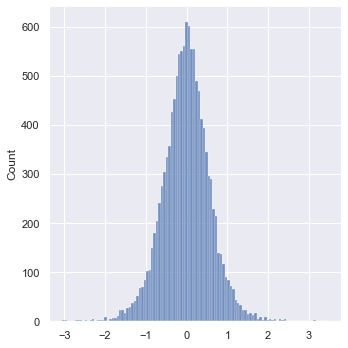

In [13]:
import seaborn as sns
sns.set()
sns.displot(torch.cat((z_a375.detach(),z_ht29.detach()),0).flatten().cpu().numpy())

In [14]:
# torch.save(autoencoder_a375,'../results/my_results/vae_a375.pt')
# torch.save(autoencoder_ht29,'../results/my_results/vae_ht29.pt')
# #torch.save(decoder_a375,'../results/my_results/decoder_a375.pt')
# #torch.save(decoder_ht29,'../results/my_results/decoder_ht29.pt')

In [15]:
valPear = np.array(valPear)
valPearDirect = np.array(valPearDirect)
crossCorrelation = np.array(crossCorrelation)
valSpear = np.array(valSpear)
valAccuracy= np.array(valAccuracy)
valSpearDirect= np.array(valSpearDirect)
valAccDirect= np.array(valAccDirect)

In [16]:
import seaborn as sns
sns.set()

Text(0.5, 0, 'Pearson correlation')

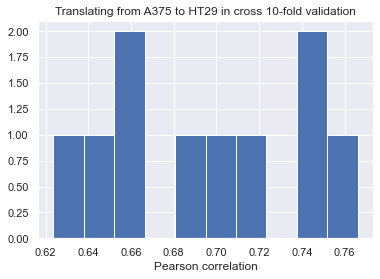

In [17]:
plt.figure()
plt.hist(valPear[:,0])
plt.title('Translating from A375 to HT29 in cross 10-fold validation')
plt.xlabel('Pearson correlation')
#plt.savefig('my_results/vae_genes_a375_to_ht29_crossval.png',dpi=600)

Text(0.5, 0, 'Pearson correlation')

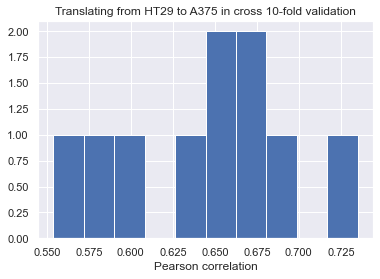

In [18]:
plt.figure()
plt.hist(valPear[:,1])
plt.title('Translating from HT29 to A375 in cross 10-fold validation')
plt.xlabel('Pearson correlation')
#plt.savefig('my_results/vae_genes_ht29_to_a375_crossval.png',dpi=600)

In [19]:
print(np.mean(valPear,axis=0))
print(np.mean(valPearDirect))
print(np.mean(crossCorrelation,axis=0))

[0.69375925 0.64480665]
0.45795060992240905
[0.5082543  0.52654321]


In [20]:
print(np.mean(valSpear,axis=0))
print(np.mean(valSpearDirect))

[0.58157382 0.56005669]
0.40821883215419613


In [21]:
print(np.mean(valAccuracy,axis=0))
print(np.mean(valAccDirect,axis=0))

[0.70302147 0.69735174]
[0.64107618 0.64107618]


In [22]:
# print(np.mean(valPear,axis=0))
# print(np.mean(valPearMean,axis=0))
# print(np.mean(valPearUniform,axis=0))
# print(np.mean(valPearScrampled,axis=0))
# print(np.mean(valPearDirect))
# print(np.mean(crossCorrelation,axis=0))

In [23]:
df_result = pd.DataFrame({'model_pearsonHT29':valPear[:,0],'model_pearsonA375':valPear[:,1],
                          'model_spearHT29':valSpear[:,0],'model_spearA375':valSpear[:,1],
                          'model_accHT29':valAccuracy[:,0],'model_accA375':valAccuracy[:,1],
                          'recon_pear_ht29':valPear_ht29 ,'recon_pear_a375':valPear_a375,
                          'recon_spear_ht29':valSpear_ht29 ,'recon_spear_a375':valSpear_a375,
                          'recon_acc_ht29':valAccuracy_ht29 ,'recon_acc_a375':valAccuracy_a375,
                          'cross_corr_ht29':crossCorrelation[:,0],'cross_corr_a375':crossCorrelation[:,1],
                          'Direct_pearson':valPearDirect,'Direct_spearman':valSpearDirect,
                          'DirectAcc_ht29':valAccDirect[:,0],'DirectAcc_a375':valAccDirect[:,1]})
df_result

,model_pearsonHT29,model_pearsonA375,model_spearHT29,model_spearA375,model_accHT29,model_accA375,recon_pear_ht29,recon_pear_a375,recon_spear_ht29,recon_spear_a375,recon_acc_ht29,recon_acc_a375,cross_corr_ht29,cross_corr_a375,Direct_pearson,Direct_spearman,DirectAcc_ht29,DirectAcc_a375
0,0.714437,0.636287,0.644605,0.588394,0.724335,0.709458,0.813698,0.789243,0.748613,0.707517,0.783538,0.761009,0.536522,0.527700,0.520686,0.463031,0.662730,0.662730
1,0.659106,0.684179,0.534432,0.564547,0.684586,0.702914,0.796625,0.777628,0.710375,0.677780,0.765235,0.752505,0.517873,0.548969,0.479417,0.420304,0.649847,0.649847
2,0.766158,0.735101,0.663785,0.647048,0.730649,0.730470,0.781684,0.798474,0.714701,0.712269,0.767578,0.764358,0.550649,0.549363,0.500422,0.432608,0.644836,0.644836
3,0.705609,0.658556,0.548605,0.542444,0.689034,0.697929,0.791703,0.781915,0.706809,0.681103,0.766211,0.755325,0.451093,0.510691,0.445524,0.393393,0.635890,0.635890
4,0.740012,0.674897,0.619869,0.594749,0.723160,0.703937,0.803919,0.792635,0.739734,0.697915,0.787628,0.758240,0.567433,0.591613,0.542872,0.442503,0.653144,0.653144
5,0.664504,0.648586,0.536080,0.549886,0.686503,0.693584,0.789403,0.785075,0.710884,0.705711,0.771575,0.766411,0.491235,0.530955,0.456026,0.433163,0.654525,0.654525
6,0.681056,0.602264,0.564668,0.519528,0.699259,0.679550,0.814751,0.781440,0.745253,0.715617,0.786912,0.768413,0.491975,0.468711,0.391251,0.353916,0.618405,0.618405
7,0.738397,0.665845,0.654128,0.612504,0.734126,0.716232,0.822334,0.775760,0.758103,0.718015,0.797388,0.771558,0.512402,0.552780,0.455651,0.433182,0.652428,0.652428
8,0.623668,0.553936,0.495293,0.471359,0.667101,0.664315,0.767386,0.766762,0.700636,0.702621,0.762707,0.763557,0.463379,0.487657,0.373686,0.337688,0.610148,0.610148
9,0.644645,0.588415,0.554273,0.510109,0.691462,0.675128,0.788528,0.735396,0.713694,0.662111,0.768015,0.745978,0.499982,0.496993,0.413972,0.372399,0.628809,0.628809


In [24]:
# df_result1 = pd.read_csv('my_results/landmarks_10foldvalidation_vae_results2000ep512bs_0to3.csv',index_col=0)
# df_result2 = pd.read_csv('my_results/landmarks_10foldvalidation_vae_results2000ep512bs_4to7.csv',index_col=0)
# df_result3 = pd.read_csv('my_results/landmarks_10foldvalidation_vae_results2000ep512bs_8to9.csv',index_col=0)
# df_result = pd.concat([df_result1,
#                        df_result2,
#                        df_result3],axis=0).reset_index(drop=True)

In [25]:
df_result.to_csv('../results/deepcellstate_results/deepcellstate_landmarks_10foldvalidation_direct_translation_results2000ep512bs.csv')

In [82]:
# from scipy.stats import pearsonr
# r , p = pearsonr(xhat.detach().cpu().flatten(),xval.detach().cpu().flatten())

# Compare my variations

In [2]:
import seaborn as sns
sns.set()

In [3]:
# res_vae_direct = pd.read_csv('my_results/landmarks_10foldvalidation_direct_translation_vae_results1000ep512bs.csv',index_col=0)
# res_vae_direct['model'] = 'variation 5'
# res_vae = pd.read_csv('my_results/landmarks_10foldvalidation_vae_results1000ep512bs.csv',index_col=0)
# res_vae['model'] = 'variation 1'
# res_vae_pretrained = pd.read_csv('my_results/landmarks_10foldvalidation_pretrained_vae_results1000ep512bs.csv',index_col=0)
# res_vae_pretrained['model'] = 'variation 2'
# res_notvae = pd.read_csv('my_results/landmarks_10foldvalidation_notvae_results1000ep512bs.csv',index_col=0)
# res_notvae['model'] = 'variation 3'
# res_direct = pd.read_csv('my_results/landmarks_10foldvalidation_direct_translation_results1000ep512bs.csv',index_col=0)
# res_direct['model'] = 'variation 4'

In [4]:
res_vae_direct = pd.read_csv('../results/my_results_10kgenes/allgenes_10foldvalidation_direct_translation_vae_results1000ep512bs.csv',index_col=0)
res_vae_direct['model'] = 'variation 5'
res_vae = pd.read_csv('../results/my_results_10kgenes/allgenes_10foldvalidation_vae_results1000ep512bs.csv',index_col=0)
res_vae['model'] = 'variation 1'
res_vae_pretrained = pd.read_csv('../results/my_results_10kgenes/allgenes_10foldvalidation_pretrained_vae_results1000ep512bs.csv',index_col=0)
res_vae_pretrained['model'] = 'variation 2'
res_notvae = pd.read_csv('../results/my_results_10kgenes/allgenes_10foldvalidation_notvae_results1000ep512bs.csv',index_col=0)
res_notvae['model'] = 'variation 3'
res_direct = pd.read_csv('../results/my_results_10kgenes/allgenes_10foldvalidation_direct_translation_not_vae_results1000ep512bs.csv',index_col=0)
res_direct['model'] = 'variation 4'

In [5]:
results = pd.concat([res_vae,res_vae_pretrained,res_notvae,res_direct,res_vae_direct],axis=0)
results

,model_pearsonHT29,model_pearsonA375,model_spearHT29,model_spearA375,model_accHT29,model_accA375,recon_pear_ht29,recon_pear_a375,recon_spear_ht29,recon_spear_a375,recon_acc_ht29,recon_acc_a375,cross_corr_ht29,cross_corr_a375,Direct_pearson,Direct_spearman,DirectAcc_ht29,DirectAcc_a375,model
0,0.672007,0.602081,0.565656,0.526510,0.701155,0.686533,0.822774,0.779324,0.762210,0.673304,0.791508,0.753181,0.576706,0.571916,0.491287,0.415190,0.642983,0.642983,variation 1
1,0.565864,0.589989,0.474451,0.465861,0.665155,0.666721,0.809804,0.753822,0.743418,0.623143,0.785214,0.730856,0.540844,0.561562,0.449773,0.373708,0.631105,0.631105,variation 1
2,0.691483,0.644011,0.579349,0.552728,0.703966,0.692574,0.752126,0.764791,0.657321,0.655778,0.745642,0.744689,0.571963,0.601047,0.467521,0.380200,0.626279,0.626279,variation 1
3,0.592448,0.523835,0.453410,0.431392,0.657500,0.654186,0.722135,0.721446,0.599709,0.594886,0.724270,0.720152,0.490115,0.556084,0.420189,0.338177,0.617376,0.617376,variation 1
4,0.658097,0.651461,0.534632,0.552374,0.688516,0.700558,0.809746,0.723825,0.748106,0.600002,0.791022,0.725187,0.615015,0.636629,0.534992,0.417309,0.646877,0.646877,variation 1
5,0.542527,0.543744,0.466458,0.422879,0.662802,0.646991,0.843694,0.822660,0.801087,0.767717,0.817127,0.798685,0.518851,0.548061,0.414236,0.365071,0.626368,0.626368,variation 1
6,0.484080,0.459723,0.420633,0.377699,0.645992,0.628805,0.774423,0.742963,0.707325,0.655868,0.771637,0.746485,0.554532,0.557212,0.305874,0.271386,0.590569,0.590569,variation 1
7,0.605198,0.574763,0.497182,0.455777,0.678587,0.661870,0.784845,0.705975,0.717525,0.610275,0.779576,0.730337,0.520934,0.614659,0.453185,0.369136,0.629967,0.629967,variation 1
8,0.420948,0.420358,0.313993,0.333600,0.604980,0.610396,0.701056,0.710100,0.626364,0.615463,0.737812,0.731377,0.491566,0.499856,0.301552,0.254713,0.581735,0.581735,variation 1
9,0.516164,0.497016,0.405352,0.400865,0.640546,0.640680,0.722740,0.701822,0.635768,0.612520,0.739901,0.730152,0.575333,0.534863,0.381603,0.307406,0.604008,0.604008,variation 1


## A375 trasnlation

In [6]:
res_to_a375 = results.loc[:,['model_pearsonA375','model_spearA375','model_accA375','model']]
res_to_a375.columns = ['pearson','spearman','accuracy','model']
res_baseline = results.loc[:,['Direct_pearson','Direct_spearman','DirectAcc_a375','model']]
res_baseline['model'] = 'direct translation'
res_baseline.columns = ['pearson','spearman','accuracy','model']
res_baseline = res_baseline.drop_duplicates()
res_to_a375 = pd.concat([res_to_a375,res_baseline],axis=0)
res_to_a375

,pearson,spearman,accuracy,model
0,0.602081,0.526510,0.686533,variation 1
1,0.589989,0.465861,0.666721,variation 1
2,0.644011,0.552728,0.692574,variation 1
3,0.523835,0.431392,0.654186,variation 1
4,0.651461,0.552374,0.700558,variation 1
5,0.543744,0.422879,0.646991,variation 1
6,0.459723,0.377699,0.628805,variation 1
7,0.574763,0.455777,0.661870,variation 1
8,0.420358,0.333600,0.610396,variation 1
9,0.497016,0.400865,0.640680,variation 1


In [129]:
res_to_a375 = pd.melt(res_to_a375,id_vars=['model'])
res_to_a375.columns = ['model','metric','value']
res_to_a375

,model,metric,value
0,variation 1,pearson,0.602081
1,variation 1,pearson,0.589989
2,variation 1,pearson,0.644011
3,variation 1,pearson,0.523835
4,variation 1,pearson,0.651461
...,...,...,...
175,direct translation,accuracy,0.626368
176,direct translation,accuracy,0.590569
177,direct translation,accuracy,0.629967
178,direct translation,accuracy,0.581735


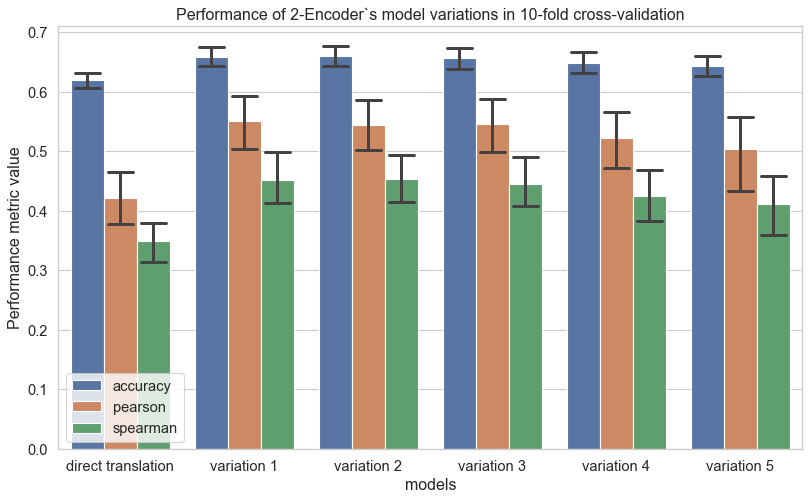

In [130]:
sns.set_theme(style="whitegrid",font_scale = 1.2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="model", y="value", data=res_to_a375,
            order=['direct translation','variation 1',
                   'variation 2','variation 3',
                   'variation 4','variation 5',],hue_order = ['accuracy','pearson','spearman'],
            hue="metric",ci=95,capsize=0.2)
plt.legend(loc='lower left')
plt.gca().set(title='Performance of 2-Encoder`s model variations in 10-fold cross-validation', 
              xlabel = 'models',
              ylabel='Performance metric value')
#plt.xticks(rotation=45)
#plt.ylim(0,1.0)
plt.savefig('../figures/my_results/10fold_validation_mymodel_variations_allgenes_a375.png', bbox_inches='tight',dpi=600)

In [131]:
from scipy import stats

In [132]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','direct translation']
pvalues_pearson = np.zeros((len(models),len(models)))
pvalues_pearson = pd.DataFrame(pvalues_pearson)
pvalues_pearson.index = models
pvalues_pearson.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='pearson'].value.values
        x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='pearson'].value.values
        pvalues_pearson.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_pearson['metric'] = 'pearson'

<ipython-input-132-0be6728a4984>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='pearson'].value.values
<ipython-input-132-0be6728a4984>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='pearson'].value.values


In [133]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','direct translation']
pvalues_spearman = np.zeros((len(models),len(models)))
pvalues_spearman = pd.DataFrame(pvalues_spearman)
pvalues_spearman.index = models
pvalues_spearman.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='spearman'].value.values
        x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='spearman'].value.values
        pvalues_spearman.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_spearman['metric'] = 'spearman'

<ipython-input-133-214a3f045d76>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='spearman'].value.values
<ipython-input-133-214a3f045d76>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='spearman'].value.values


In [134]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','direct translation']
pvalues_accuracy = np.zeros((len(models),len(models)))
pvalues_accuracy = pd.DataFrame(pvalues_accuracy)
pvalues_accuracy.index = models
pvalues_accuracy.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='accuracy'].value.values
        x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='accuracy'].value.values
        pvalues_accuracy.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_accuracy['metric'] = 'accuracy'

<ipython-input-134-350cd7f9bb57>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='accuracy'].value.values
<ipython-input-134-350cd7f9bb57>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='accuracy'].value.values


In [135]:
a375_translate = pd.concat([pvalues_pearson,pvalues_spearman,pvalues_accuracy],axis=0)
a375_translate = a375_translate[['metric','variation 1','variation 2','variation 3','variation 4','variation 5','direct translation']]
a375_translate.to_csv('../results/my_results/a375_allgenes_translation_pvalues_table.csv')
a375_translate

,metric,variation 1,variation 2,variation 3,variation 4,variation 5,direct translation
variation 1,pearson,1.0,0.791337,0.791337,0.384673,0.384673,0.002827
variation 2,pearson,0.0,1.000000,0.969850,0.520523,0.344704,0.005795
variation 3,pearson,0.0,0.000000,1.000000,0.427355,0.307489,0.003611
variation 4,pearson,0.0,0.000000,0.000000,1.000000,0.791337,0.021134
variation 5,pearson,0.0,0.000000,0.000000,0.000000,1.000000,0.031209
direct translation,pearson,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
variation 1,spearman,1.0,0.909722,0.850107,0.384673,0.384673,0.004586
variation 2,spearman,0.0,1.000000,0.677585,0.427355,0.241322,0.007285
variation 3,spearman,0.0,0.000000,1.000000,0.384673,0.520523,0.003611
variation 4,spearman,0.0,0.000000,0.000000,1.000000,0.850107,0.025748


### Same but for reconstruction

In [136]:
res_recon_a375 = results.loc[:,['recon_pear_a375','recon_spear_a375','recon_acc_a375','model']]
res_recon_a375.columns = ['pearson','spearman','accuracy','model']
res_recon_a375

,pearson,spearman,accuracy,model
0,0.779324,0.673304,0.753181,variation 1
1,0.753822,0.623143,0.730856,variation 1
2,0.764791,0.655778,0.744689,variation 1
3,0.721446,0.594886,0.720152,variation 1
4,0.723825,0.600002,0.725187,variation 1
5,0.822660,0.767717,0.798685,variation 1
6,0.742963,0.655868,0.746485,variation 1
7,0.705975,0.610275,0.730337,variation 1
8,0.710100,0.615463,0.731377,variation 1
9,0.701822,0.612520,0.730152,variation 1


In [137]:
res_recon_a375 = pd.melt(res_recon_a375,id_vars=['model'])
res_recon_a375.columns = ['model','metric','value']
res_recon_a375

,model,metric,value
0,variation 1,pearson,0.779324
1,variation 1,pearson,0.753822
2,variation 1,pearson,0.764791
3,variation 1,pearson,0.721446
4,variation 1,pearson,0.723825
...,...,...,...
145,variation 5,accuracy,0.732579
146,variation 5,accuracy,0.690598
147,variation 5,accuracy,0.715169
148,variation 5,accuracy,0.723879


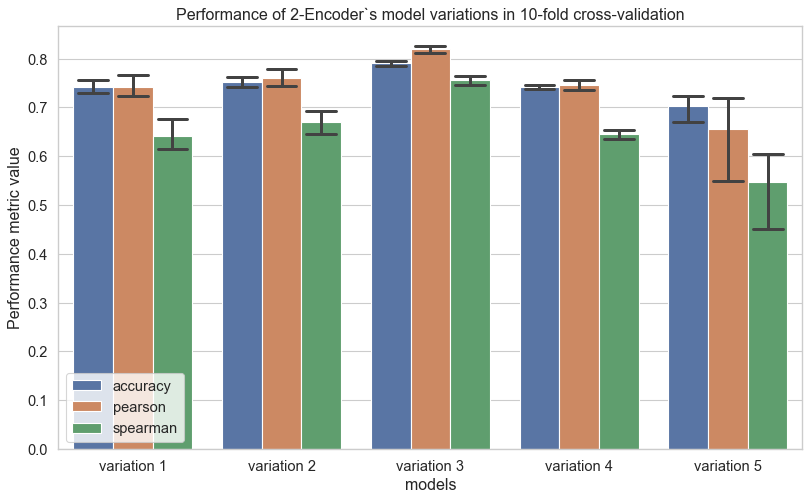

In [138]:
sns.set_theme(style="whitegrid",font_scale = 1.2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="model", y="value", data=res_recon_a375,
            order=['variation 1','variation 2','variation 3','variation 4','variation 5'],
            hue_order = ['accuracy','pearson','spearman'],
            hue="metric",ci=95,capsize=0.2)
plt.legend(loc='lower left')
plt.gca().set(title='Performance of 2-Encoder`s model variations in 10-fold cross-validation', 
              xlabel = 'models',
              ylabel='Performance metric value')
#plt.xticks(rotation=45)
#plt.ylim(0,1.0)
plt.savefig('../figures/my_results/10fold_validation_reconstruction_mymodel_variations_allgenes_a375.png', bbox_inches='tight',dpi=600)

In [139]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5']
pvalues_pearson = np.zeros((len(models),len(models)))
pvalues_pearson = pd.DataFrame(pvalues_pearson)
pvalues_pearson.index = models
pvalues_pearson.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='pearson'].value.values
        x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='pearson'].value.values
        pvalues_pearson.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_pearson['metric'] = 'pearson'

<ipython-input-139-6547a231eb66>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_a375[res_to_a375['model']==m1][res_to_a375['metric']=='pearson'].value.values
<ipython-input-139-6547a231eb66>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_a375[res_to_a375['model']==m2][res_to_a375['metric']=='pearson'].value.values


In [140]:
pvalues_spearman = np.zeros((len(models),len(models)))
pvalues_spearman = pd.DataFrame(pvalues_spearman)
pvalues_spearman.index = models
pvalues_spearman.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_a375[res_recon_a375['model']==m1][res_recon_a375['metric']=='spearman'].value.values
        x2 = res_recon_a375[res_recon_a375['model']==m2][res_recon_a375['metric']=='spearman'].value.values
        pvalues_spearman.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_spearman['metric'] = 'spearman'

<ipython-input-140-db2d8645d6f5>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_a375[res_recon_a375['model']==m1][res_recon_a375['metric']=='spearman'].value.values
<ipython-input-140-db2d8645d6f5>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_a375[res_recon_a375['model']==m2][res_recon_a375['metric']=='spearman'].value.values


In [141]:
pvalues_accuracy = np.zeros((len(models),len(models)))
pvalues_accuracy = pd.DataFrame(pvalues_accuracy)
pvalues_accuracy.index = models
pvalues_accuracy.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_a375[res_recon_a375['model']==m1][res_recon_a375['metric']=='accuracy'].value.values
        x2 = res_recon_a375[res_recon_a375['model']==m2][res_recon_a375['metric']=='accuracy'].value.values
        pvalues_accuracy.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_accuracy['metric'] = 'accuracy'

<ipython-input-141-7bf8ce6c3d50>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_a375[res_recon_a375['model']==m1][res_recon_a375['metric']=='accuracy'].value.values
<ipython-input-141-7bf8ce6c3d50>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_a375[res_recon_a375['model']==m2][res_recon_a375['metric']=='accuracy'].value.values


In [142]:
a375_reconstruction = pd.concat([pvalues_pearson,pvalues_spearman,pvalues_accuracy],axis=0)
a375_reconstruction = a375_reconstruction[['metric','variation 1','variation 2','variation 3','variation 4','variation 5']]
a375_reconstruction.to_csv('../results/my_results/a375_allgenes_reconstruction_pvalues_table.csv')
a375_reconstruction

,metric,variation 1,variation 2,variation 3,variation 4,variation 5
variation 1,pearson,1.0,0.791337,0.791337,0.384673,0.384673
variation 2,pearson,0.0,1.000000,0.969850,0.520523,0.344704
variation 3,pearson,0.0,0.000000,1.000000,0.427355,0.307489
variation 4,pearson,0.0,0.000000,0.000000,1.000000,0.791337
variation 5,pearson,0.0,0.000000,0.000000,0.000000,1.000000
variation 1,spearman,1.0,0.161972,0.001315,0.307489,0.007285
variation 2,spearman,0.0,1.000000,0.000183,0.161972,0.001315
variation 3,spearman,0.0,0.000000,1.000000,0.000183,0.000183
variation 4,spearman,0.0,0.000000,0.000000,1.000000,0.001706
variation 5,spearman,0.0,0.000000,0.000000,0.000000,1.000000


## HT29 trasnlation

In [160]:
res_to_ht29 = results.loc[:,['model_pearsonHT29','model_spearHT29','model_accHT29','model']]
res_to_ht29.columns = ['pearson','spearman','accuracy','model']
res_baseline = results.loc[:,['Direct_pearson','Direct_spearman','DirectAcc_ht29','model']]
res_baseline['model'] = 'direct translation'
res_baseline.columns = ['pearson','spearman','accuracy','model']
res_baseline = res_baseline.drop_duplicates()
res_to_ht29 = pd.concat([res_to_ht29,res_baseline],axis=0)
res_to_ht29

,pearson,spearman,accuracy,model
0,0.736646,0.645384,0.725102,variation 1
1,0.688052,0.585091,0.704550,variation 1
2,0.789633,0.682697,0.741258,variation 1
3,0.715470,0.578769,0.707106,variation 1
4,0.737922,0.626056,0.721293,variation 1
5,0.677289,0.558449,0.694504,variation 1
6,0.676079,0.571399,0.700179,variation 1
7,0.741913,0.677114,0.744427,variation 1
8,0.652741,0.524586,0.679831,variation 1
9,0.650536,0.564798,0.694785,variation 1


In [161]:
res_to_ht29 = pd.melt(res_to_ht29,id_vars=['model'])
res_to_ht29.columns = ['model','metric','value']
res_to_ht29

,model,metric,value
0,variation 1,pearson,0.736646
1,variation 1,pearson,0.688052
2,variation 1,pearson,0.789633
3,variation 1,pearson,0.715470
4,variation 1,pearson,0.737922
...,...,...,...
175,direct translation,accuracy,0.654525
176,direct translation,accuracy,0.618405
177,direct translation,accuracy,0.652428
178,direct translation,accuracy,0.610148


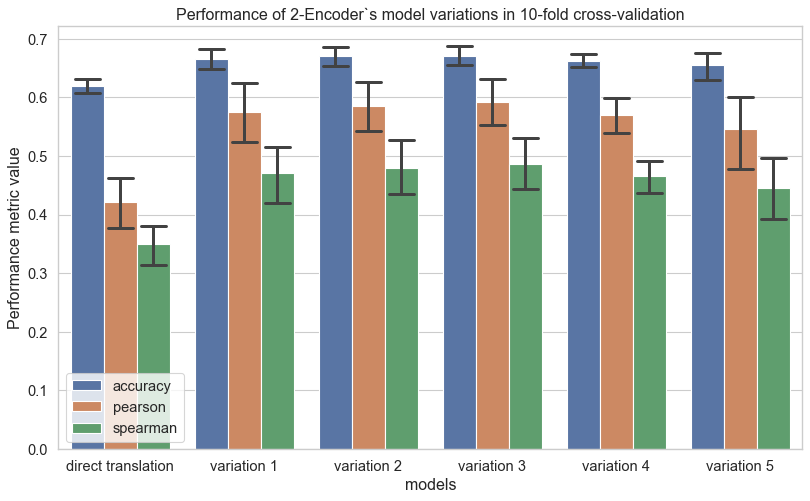

In [145]:
sns.set_theme(style="whitegrid",font_scale = 1.2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="model", y="value", data=res_to_ht29,
            order=['direct translation','variation 1',
                   'variation 2','variation 3',
                   'variation 4','variation 5'],hue_order = ['accuracy','pearson','spearman'],
            hue="metric",ci=95,capsize=0.2)
plt.legend(loc='lower left')
plt.gca().set(title='Performance of 2-Encoder`s model variations in 10-fold cross-validation', 
              xlabel = 'models',
              ylabel='Performance metric value')
#plt.xticks(rotation=45)
#plt.ylim(0,1.0)
plt.savefig('../figures/my_results/10fold_validation_mymodel_variations_allgenes_ht29.png', bbox_inches='tight',dpi=600)

In [162]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','direct translation']
pvalues_pearson = np.zeros((len(models),len(models)))
pvalues_pearson = pd.DataFrame(pvalues_pearson)
pvalues_pearson.index = models
pvalues_pearson.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='pearson'].value.values
        x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='pearson'].value.values
        pvalues_pearson.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_pearson['metric'] = 'pearson'

<ipython-input-162-dad5e446b7f8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='pearson'].value.values
<ipython-input-162-dad5e446b7f8>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='pearson'].value.values


In [163]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','direct translation']
pvalues_spearman = np.zeros((len(models),len(models)))
pvalues_spearman = pd.DataFrame(pvalues_spearman)
pvalues_spearman.index = models
pvalues_spearman.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='spearman'].value.values
        x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='spearman'].value.values
        pvalues_spearman.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_spearman['metric'] = 'spearman'

<ipython-input-163-e972e1ef8e5f>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='spearman'].value.values
<ipython-input-163-e972e1ef8e5f>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='spearman'].value.values


In [164]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5','direct translation']
pvalues_accuracy = np.zeros((len(models),len(models)))
pvalues_accuracy = pd.DataFrame(pvalues_accuracy)
pvalues_accuracy.index = models
pvalues_accuracy.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='accuracy'].value.values
        x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='accuracy'].value.values
        pvalues_accuracy.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_accuracy['metric'] = 'accuracy'

<ipython-input-164-53f6b0fbe513>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_to_ht29[res_to_ht29['model']==m1][res_to_ht29['metric']=='accuracy'].value.values
<ipython-input-164-53f6b0fbe513>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_to_ht29[res_to_ht29['model']==m2][res_to_ht29['metric']=='accuracy'].value.values


In [165]:
ht29_translate = pd.concat([pvalues_pearson,pvalues_spearman,pvalues_accuracy],axis=0)
ht29_translate = ht29_translate[['metric','variation 1','variation 2','variation 3','variation 4','variation 5','direct translation']]
ht29_translate.to_csv('../results/my_results/ht29_allgenes_translation_pvalues_table.csv')
ht29_translate

,metric,variation 1,variation 2,variation 3,variation 4,variation 5,direct translation
variation 1,pearson,1.0,0.791337,0.570750,0.520523,0.161972,0.000183
variation 2,pearson,0.0,1.000000,0.850107,0.273036,0.121225,0.000183
variation 3,pearson,0.0,0.000000,1.000000,0.307489,0.140465,0.000183
variation 4,pearson,0.0,0.000000,0.000000,1.000000,0.472676,0.000183
variation 5,pearson,0.0,0.000000,0.000000,0.000000,1.000000,0.000183
direct translation,pearson,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
variation 1,spearman,1.0,0.520523,0.677585,0.344704,0.140465,0.000183
variation 2,spearman,0.0,1.000000,1.000000,0.241322,0.140465,0.000183
variation 3,spearman,0.0,0.000000,1.000000,0.241322,0.104110,0.000183
variation 4,spearman,0.0,0.000000,0.000000,1.000000,0.623176,0.000183


### Same but for reconstruction

In [166]:
res_recon_ht29 = results.loc[:,['recon_pear_ht29','recon_spear_ht29','recon_acc_ht29','model']]
res_recon_ht29.columns = ['pearson','spearman','accuracy','model']
res_recon_ht29

,pearson,spearman,accuracy,model
0,0.832066,0.773247,0.795176,variation 1
1,0.817001,0.748985,0.781939,variation 1
2,0.808959,0.751263,0.784477,variation 1
3,0.801105,0.712601,0.766025,variation 1
4,0.839049,0.785402,0.807883,variation 1
5,0.839488,0.783279,0.807817,variation 1
6,0.837043,0.779260,0.804044,variation 1
7,0.841193,0.786428,0.809983,variation 1
8,0.820177,0.767310,0.796886,variation 1
9,0.819174,0.758950,0.787711,variation 1


In [167]:
res_recon_ht29 = pd.melt(res_recon_ht29,id_vars=['model'])
res_recon_ht29.columns = ['model','metric','value']
res_recon_ht29

,model,metric,value
0,variation 1,pearson,0.832066
1,variation 1,pearson,0.817001
2,variation 1,pearson,0.808959
3,variation 1,pearson,0.801105
4,variation 1,pearson,0.839049
...,...,...,...
145,variation 5,accuracy,0.769836
146,variation 5,accuracy,0.770245
147,variation 5,accuracy,0.791309
148,variation 5,accuracy,0.767336


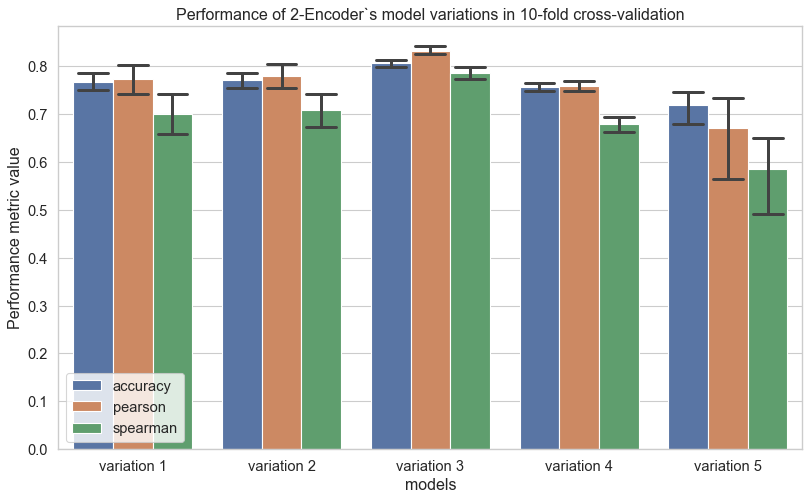

In [152]:
sns.set_theme(style="whitegrid",font_scale = 1.2)
plt.figure(figsize=(12,7), dpi= 80)
sns.barplot(x="model", y="value", data=res_recon_ht29,
            order=['variation 1','variation 2','variation 3','variation 4','variation 5'],
            hue_order = ['accuracy','pearson','spearman'],
            hue="metric",ci=95,capsize=0.2)
plt.legend(loc='lower left')
plt.gca().set(title='Performance of 2-Encoder`s model variations in 10-fold cross-validation', 
              xlabel = 'models',
              ylabel='Performance metric value')
#plt.xticks(rotation=45)
#plt.ylim(0,1.0)
plt.savefig('../figures/my_results/10fold_validation_reconstruction_mymodel_variations_allgenes_ht29.png', bbox_inches='tight',dpi=600)

In [168]:
models = ['variation 1','variation 2','variation 3','variation 4','variation 5']
pvalues_pearson = np.zeros((len(models),len(models)))
pvalues_pearson = pd.DataFrame(pvalues_pearson)
pvalues_pearson.index = models
pvalues_pearson.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='pearson'].value.values
        x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='pearson'].value.values
        pvalues_pearson.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_pearson['metric'] = 'pearson'

<ipython-input-168-532106056683>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='pearson'].value.values
<ipython-input-168-532106056683>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='pearson'].value.values


In [169]:
pvalues_spearman = np.zeros((len(models),len(models)))
pvalues_spearman = pd.DataFrame(pvalues_spearman)
pvalues_spearman.index = models
pvalues_spearman.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='spearman'].value.values
        x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='spearman'].value.values
        pvalues_spearman.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_spearman['metric'] = 'spearman'

<ipython-input-169-d8298965d0b4>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='spearman'].value.values
<ipython-input-169-d8298965d0b4>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='spearman'].value.values


In [170]:
pvalues_accuracy = np.zeros((len(models),len(models)))
pvalues_accuracy = pd.DataFrame(pvalues_accuracy)
pvalues_accuracy.index = models
pvalues_accuracy.columns = models
for i in range(len(models)):
    for j in range(i,len(models)):
        m1 = models[i]
        m2 = models[j]
        x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='accuracy'].value.values
        x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='accuracy'].value.values
        pvalues_accuracy.loc[m1,m2] = stats.mannwhitneyu(x1,x2)[1]
pvalues_accuracy['metric'] = 'accuracy'

<ipython-input-170-12b8fd9ef33b>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = res_recon_ht29[res_recon_ht29['model']==m1][res_recon_ht29['metric']=='accuracy'].value.values
<ipython-input-170-12b8fd9ef33b>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = res_recon_ht29[res_recon_ht29['model']==m2][res_recon_ht29['metric']=='accuracy'].value.values


In [171]:
ht29_reconstruction = pd.concat([pvalues_pearson,pvalues_spearman,pvalues_accuracy],axis=0)
ht29_reconstruction = ht29_reconstruction[['metric','variation 1','variation 2','variation 3','variation 4','variation 5']]
ht29_reconstruction.to_csv('../results/my_results/ht29_allgenes_reconstruction_pvalues_table.csv')
ht29_reconstruction

,metric,variation 1,variation 2,variation 3,variation 4,variation 5
variation 1,pearson,1.0,0.677585,0.850107,0.000440,0.000440
variation 2,pearson,0.0,1.000000,0.384673,0.000583,0.000583
variation 3,pearson,0.0,0.000000,1.000000,0.000246,0.000246
variation 4,pearson,0.0,0.000000,0.000000,1.000000,0.677585
variation 5,pearson,0.0,0.000000,0.000000,0.000000,1.000000
variation 1,spearman,1.0,0.677585,0.791337,0.000769,0.000440
variation 2,spearman,0.0,1.000000,0.307489,0.000330,0.000583
variation 3,spearman,0.0,0.000000,1.000000,0.000183,0.000246
variation 4,spearman,0.0,0.000000,0.000000,1.000000,0.969850
variation 5,spearman,0.0,0.000000,0.000000,0.000000,1.000000
